# Neural networks with PyTorch

Next I'll show you how to build a neural network with PyTorch.

In [217]:
# Import things like usual

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import torch

import helper

import matplotlib.pyplot as plt                    
from torchvision import datasets, transforms  


#to make this torch vision work


# conda install -c peterjc123 pytorch
# pip install torchvision
# pip install --upgrade Pillow
# conda install -c peterjc123 vc

First up, we need to get our dataset. This is provided through the `torchvision` package. The code below will download the MNIST dataset, then create training and test datasets for us. Don't worry too much about the details here, you'll learn more about this later.

In [218]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                             ])
# Download and load the training data
trainset = datasets.MNIST('MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.MNIST('MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

In [236]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

We have the training data loaded into `trainloader` and we make that an iterator with `iter(trainloader)`. We'd use this to loop through the dataset for training, but here I'm just grabbing the first batch so we can check out the data. We can see below that `images` is just a tensor with size (64, 1, 28, 28). So, 64 images per batch, 1 color channel, and 28x28 images.

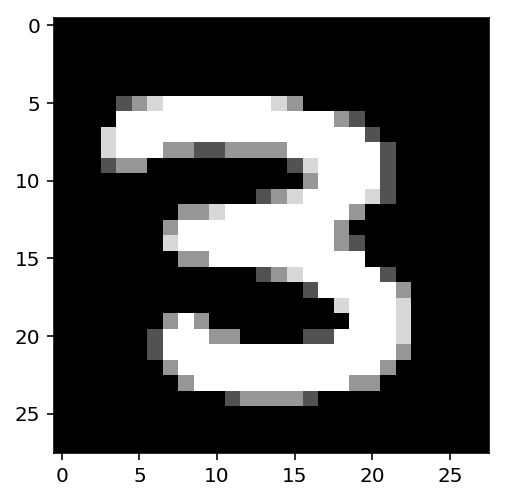

In [172]:
plt.imshow(images[1].numpy().squeeze(), cmap='Greys_r');

## Building networks with PyTorch

Here I'll use PyTorch to build a simple feedfoward network to classify the MNIST images. That is, the network will receive a digit image as input and predict the digit in the image.

<img src="assets/mlp_mnist.png" width=600px>

To build a neural network with PyTorch, you use the `torch.nn` module. The network itself is a class inheriting from `torch.nn.Module`. You define each of the operations separately, like `nn.Linear(784, 128)` for a fully connected linear layer with 784 inputs and 128 units.

The class needs to include a `forward` method that implements the forward pass through the network. In this method, you pass some input tensor `x` through each of the operations you defined earlier. The `torch.nn` module also has functional equivalents for things like ReLUs in `torch.nn.functional`. This module is usually imported as `F`. Then to use a ReLU activation on some layer (which is just a tensor), you'd do `F.relu(x)`. Below are a few different commonly used activation functions.

<img src="assets/activation.png" width=700px>

So, for this network, I'll build it with three fully connected layers, then a softmax output for predicting classes. The softmax function is similar to the sigmoid in that it squashes inputs between 0 and 1, but it's also normalized so that all the values sum to one like a proper probability distribution.

In [220]:
from torch import nn
from torch import optim
import torch.nn.functional as F

In [228]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        # Defining the layers, 128, 64, 10 units each
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 64)
        # Output layer, 10 units - one for each digit
        self.fc3 = nn.Linear(64, 10)
        
    def forward(self, x):
        ''' Forward pass through the network, returns the output logits '''
        #x = x.type(torch.FloatTensor)
        #x = Variable(x).view(1,1,input_size)
        
        #x = Variable(torch.randn(N, D_in)) 
        #y = Variable(torch.randn(N, D_out))
        x=torch.autograd.Variable(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.softmax(x, dim=1)   #dim =1 means outputsize from a vector of [input_size,output_size] 
        
        return x

model = Network()
model

Network(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

### Initializing weights and biases

The weights and such are automatically initialized for you, but it's possible to customize how they are initialized. The weights and biases are tensors attached to the layer you defined, you can get them with `model.fc1.weight` for instance.

In [175]:
print(model.fc1.weight)
print(model.fc1.bias)

Parameter containing:
 1.9981e-02  1.2431e-02 -2.1894e-02  ...   2.2993e-02 -2.3380e-02 -3.3183e-02
 7.2392e-04  1.9834e-02 -2.1533e-02  ...  -2.2398e-02 -1.8268e-02 -2.5546e-04
-2.2094e-02  3.3979e-02 -4.0841e-03  ...  -1.8071e-02  3.2152e-02 -9.2413e-03
                ...                   ⋱                   ...                
 1.0717e-03 -2.4434e-02 -2.5404e-02  ...   1.0727e-02  2.4895e-02  1.1461e-02
 3.4436e-02  3.4340e-02  2.0782e-02  ...  -2.0963e-02 -2.6645e-02 -6.0252e-03
 4.5188e-03 -2.7714e-02 -1.6533e-02  ...   3.1196e-02  7.4171e-03  6.1126e-03
[torch.FloatTensor of size 128x784]

Parameter containing:
1.00000e-02 *
  0.5508
 -0.0800
  0.4088
  2.6455
 -1.6741
 -2.0016
 -0.9067
  0.7239
 -2.9653
 -2.8696
 -0.3224
  1.8648
  1.4188
 -0.8433
  2.5646
  0.6132
  2.5417
 -1.2002
 -2.8525
  3.4020
 -1.5060
  0.8068
 -2.1937
 -0.7201
 -2.0623
  3.4228
  1.0377
  1.6618
 -2.1640
 -0.5914
  2.9203
 -1.1625
 -0.7896
 -0.7591
 -0.6032
 -3.2222
 -2.1038
  0.4213
 -0.4741
 -0.1803

For custom initialization, we want to modify these tensors in place. These are actually autograd *Variables*, so we need to get back the actual tensors with `model.fc1.weight.data`. Once we have the tensors, we can fill them with zeros (for biases) or random normal values.

In [176]:
# Set biases to all zeros
#model.fc1.bias.data.fill_(0)

In [177]:
# sample from random normal with standard dev = 0.01
#model.fc1.weight.data.normal_(std=0.01)

### Forward pass

Now that we have a network, let's see what happens when we pass in an image. This is called the forward pass. We're going to convert the image data into a tensor, then pass it through the operations defined by the network architecture.

In [207]:
# # Grab some data 
# dataiter = iter(trainloader)   #batch of 64
# images, labels = dataiter.next()  #every time get the next batch  64 sample
# #print(images.size())  torch.Size([64, 1, 28, 28])
# # Resize images into a 1D vector, new shape is (batch size, color channels, image pixels) 
# images.resize_(64, 1, 784)
# # or images.resize_(images.shape[0], 1, 784) to not automatically get batch size

# # Forward pass through the network
# img_idx = 0

# #a=torch.autograd.Variable(images)
# #ps = model.forward(a[img_idx,:])

# temp_=torch.autograd.Variable(images[img_idx,:])
# ps = model.forward(temp_)   # had to convert images into variable to be able to go through forward done inside forward
# #ps = model.forward(temp_[img_idx,:])
# img = images[img_idx]
# helper.view_classify(img.view(1, 28, 28), ps)

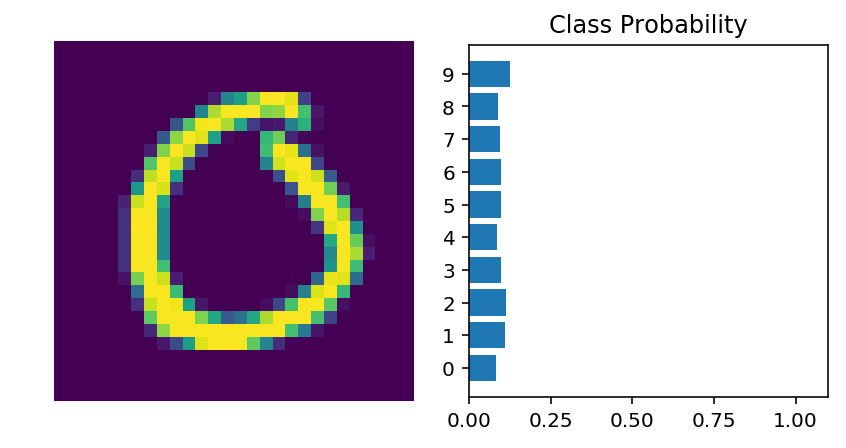

In [229]:
# Grab some data    This part is by changing forward and put variable there
#dataiter = iter(trainloader)   #batch of 64
#images, labels = dataiter.next()  #every time get the next batch  64 sample
images, labels = next(iter(trainloader))

#print(images.size())  torch.Size([64, 1, 28, 28])
# Resize images into a 1D vector, new shape is (batch size, color channels, image pixels) 
images.resize_(64, 1, 784)
# or images.resize_(images.shape[0], 1, 784) to not automatically get batch size

# Forward pass through the network
img_idx = 10

#a=torch.autograd.Variable(images)
#ps = model.forward(a[img_idx,:])

#temp_=torch.autograd.Variable(images[img_idx,:])
#ps = model.forward(temp_)   # had to convert images into variable to be able to go through forward done inside forward
ps = model.forward(images[img_idx,:])   #this forward gets the data from subroutime above
img = images[img_idx]
helper.view_classify(img.view(1, 28, 28), ps)

As you can see above, our network has basically no idea what this digit is. It's because we haven't trained it yet, all the weights are random!

PyTorch provides a convenient way to build networks like this where a tensor is passed sequentially through operations, `nn.Sequential` ([documentation](https://pytorch.org/docs/master/nn.html#torch.nn.Sequential)). Using this to build the equivalent network:

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): Softmax()
)


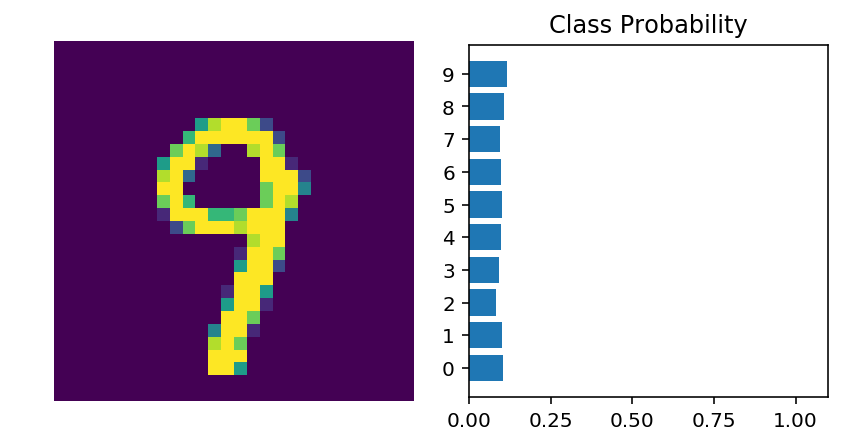

In [222]:
# Hyperparameters for our network
input_size = 784
hidden_sizes = [128, 64]
output_size = 10

# Build a feed-forward network
model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.Softmax(dim=1))
print(model)

# Forward pass through the network and display output
images, labels = next(iter(trainloader))
images.resize_(images.shape[0], 1, 784)
a=torch.autograd.Variable(images)
ps = model.forward(a[0,:])     #don't think this is the same forward as subroutine above, so had to add variable before it
helper.view_classify(images[0].view(1, 28, 28), ps)

You can also pass in an `OrderedDict` to name the individual layers and operations. Note that a dictionary keys must be unique, so _each operation must have a different name_.

In [223]:
from collections import OrderedDict
model = nn.Sequential(OrderedDict([
                      ('fc1', nn.Linear(input_size, hidden_sizes[0])),
                      ('relu1', nn.ReLU()),
                      ('fc2', nn.Linear(hidden_sizes[0], hidden_sizes[1])),
                      ('relu2', nn.ReLU()),
                      ('output', nn.Linear(hidden_sizes[1], output_size)),
                      ('softmax', nn.Softmax(dim=1))]))
model

Sequential(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (relu2): ReLU()
  (output): Linear(in_features=64, out_features=10, bias=True)
  (softmax): Softmax()
)

Now it's your turn to build a simple network, use any method I've covered so far. In the next notebook, you'll learn how to train a network so it can make good predictions.

>**Exercise:** Build a network to classify the MNIST images with _three_ hidden layers. Use 400 units in the first hidden layer, 200 units in the second layer, and 100 units in the third layer. Each hidden layer should have a ReLU activation function, and use softmax on the output layer. 

In [232]:
## TODO: Your network here

# Hyperparameters for our network
input_size = 784
hidden_sizes = [400, 200,100]
output_size = 10

# Build a feed-forward network
model2 = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),  # 784*400
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),    # 400*200
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], hidden_sizes[2]),    # 200*100
                      nn.ReLU(),                      
                      nn.Linear(hidden_sizes[2], output_size),        #100*10    
                      nn.Softmax(dim=1))  #dim =1 means output_size from a vector of [input_size,output_size] 

from collections import OrderedDict
model2 = nn.Sequential(OrderedDict([
                      ('fc1', nn.Linear(input_size, hidden_sizes[0])),
                      ('relu1', nn.ReLU()),
                      ('fc2', nn.Linear(hidden_sizes[0], hidden_sizes[1])),
                      ('relu2', nn.ReLU()),
                      ('fc3', nn.Linear(hidden_sizes[1], hidden_sizes[2])),
                      ('relu3', nn.ReLU()),    
                      ('output', nn.Linear(hidden_sizes[2], output_size)),
                      ('softmax', nn.Softmax(dim=1))]))
model2

Sequential(
  (fc1): Linear(in_features=784, out_features=400, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=400, out_features=200, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=200, out_features=100, bias=True)
  (relu3): ReLU()
  (output): Linear(in_features=100, out_features=10, bias=True)
  (softmax): Softmax()
)

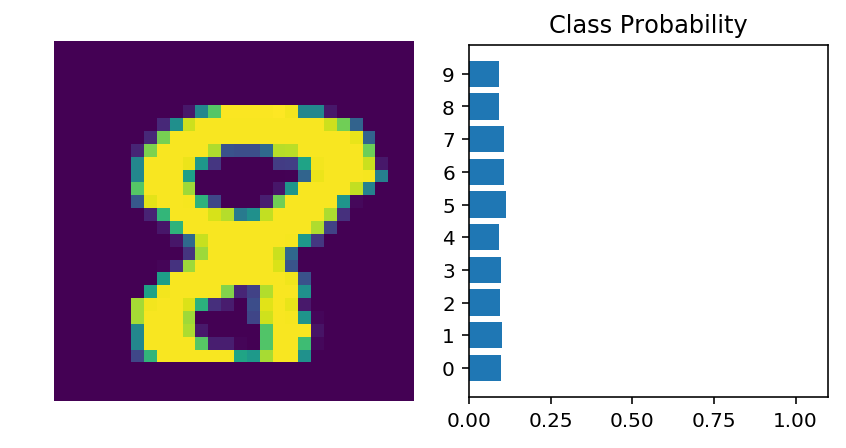

In [233]:
## Run this cell with your model to make sure it works ##
# Forward pass through the network and display output
images, labels = next(iter(trainloader))
images.resize_(images.shape[0], 1, 784)

ps = model2.forward(torch.autograd.Variable(images[0,:]))
helper.view_classify(images[0].view(1, 28, 28), ps)